In [1]:
# %load_ext autoreload
# %autoreload 2

import matplotlib.pyplot as plt
# %matplotlib widget
import pandas as pd
pd.set_option("display.max_rows", None)
import numpy as np 
import seaborn as sns

import datetime as dt
import math

I could...

- use unsupervised learning classification
- Change detection in time series
- denoising ?

# Extract feature code

In [2]:
def clean_data(data):
    # Converting object type to datetime
    data["device_local_date"] = pd.to_datetime(data["device_local_date"])
    # removing duplicates
    return data.drop_duplicates()

def keep_one_ping_per_device_per_slice(data, slice_len=30):
    """Only keep one ping per device per slice of `slice_len` minutes.`"""
    data["week_slice_id"] = data["device_local_date"].apply(lambda t: (t.weekday() * 3600 + t.hour * 60 + t.minute) // slice_len)
    return data.drop_duplicates(subset=["shopping_center_id", "week_slice_id", "device_hash_id"])

def get_ping_by_slice(data, slice_len=30):
    data = data.copy()
    data = clean_data(data)    
    
    data["ping_weekday"] = data["device_local_date"].dt.weekday
    data["day_slice_id"] = data["device_local_date"].apply(lambda t: (t.hour * 60 + t.minute) // slice_len)
    
    u_data = keep_one_ping_per_device_per_slice(data, slice_len)

    ping_by_slice_by_weekday = {}

    for weekday in range(7):
        day_data = u_data[u_data["device_local_date"].dt.weekday == weekday]
        day_data_grouped = day_data.groupby(["day_slice_id"])
        ping_by_slice_by_weekday[weekday] = [len(day_data_grouped.get_group(i).index) if i in day_data_grouped.groups else 0 for i in range(math.ceil(24 * 60 // slice_len))]
    
    return ping_by_slice_by_weekday

In [3]:
data = pd.read_csv("./at_home_test_data_study_centers_201909.csv.csv")
data_by_center = data.groupby("shopping_center_id")

In [4]:
center_name = "b43e9e4f-acd1-4941-874d-e0c5650ab91e"
test = get_ping_by_slice(data_by_center.get_group(center_name), slice_len=60)
print(test.keys())
print(test[0])

dict_keys([0, 1, 2, 3, 4, 5, 6])
[1, 0, 0, 2, 1, 2, 3, 10, 21, 35, 38, 41, 51, 37, 37, 38, 47, 49, 49, 29, 17, 9, 4, 0]


# Test solution

In [5]:
data = pd.read_csv("./at_home_test_data_study_centers_201909.csv.csv")
data_by_center = data.groupby("shopping_center_id")

all_center = {}
for center in data_by_center.groups.keys():
    all_center[center] = get_ping_by_slice(data_by_center.get_group(center))

print(all_center.keys())
# print(all_center["b43e9e4f-acd1-4941-874d-e0c5650ab91e"][0])

dict_keys(['0cd35523-1eca-4f09-ab0d-0b506ae9d986', '599cb959-11ef-49aa-9eb3-e6c17b4ea6ba', 'b43e9e4f-acd1-4941-874d-e0c5650ab91e', 'cb2d5bb6-c372-4a51-8231-4ffa288a0c28'])


In [6]:
def test_solution_fn(predict_fn, all_center_data):
    y_val = np.arange(0, 24, 24 / 48)

    df = pd.DataFrame({
        "shopping_center_id": [center for center, c in all_center_data.items() for val in c.values() for _ in val],
        "weekday": [w for c in all_center_data.values() for w, val in c.items() for _ in val],
        "ping": [nbr for c in all_center_data.values() for val in c.values() for nbr in val],
        "time": [nbr for c in all_center_data.values() for val in c.values() for nbr in y_val],
        
        # fit by day
        # "is_open": [cat for c in all_center_data.values() for val in c.values() for cat in predict_open_with_kmeans(val)]
        
        # fit by shopping center
        "is_open": [cat for c in all_center_data.values() for cat_lst in predict_fn(c).values() for cat in cat_lst]
    })

    sns.catplot(data=df, x="time", y="ping", kind="bar", row="shopping_center_id", col="weekday", hue="is_open")
    plt.xticks(range(0,25))
    # plt.show()

    return df

    

# Simple solution

In [7]:
def predict_open_with_treshold(center_data, threshold=0.2):
    all_ping = [ping for ping_lst in center_data.values() for ping in ping_lst]
    max_v, min_v = max(all_ping), min(all_ping)
    return {k: ((np.array(ping_lst) - min_v) / (max_v - min_v)) > threshold for k, ping_lst in center_data.items()}

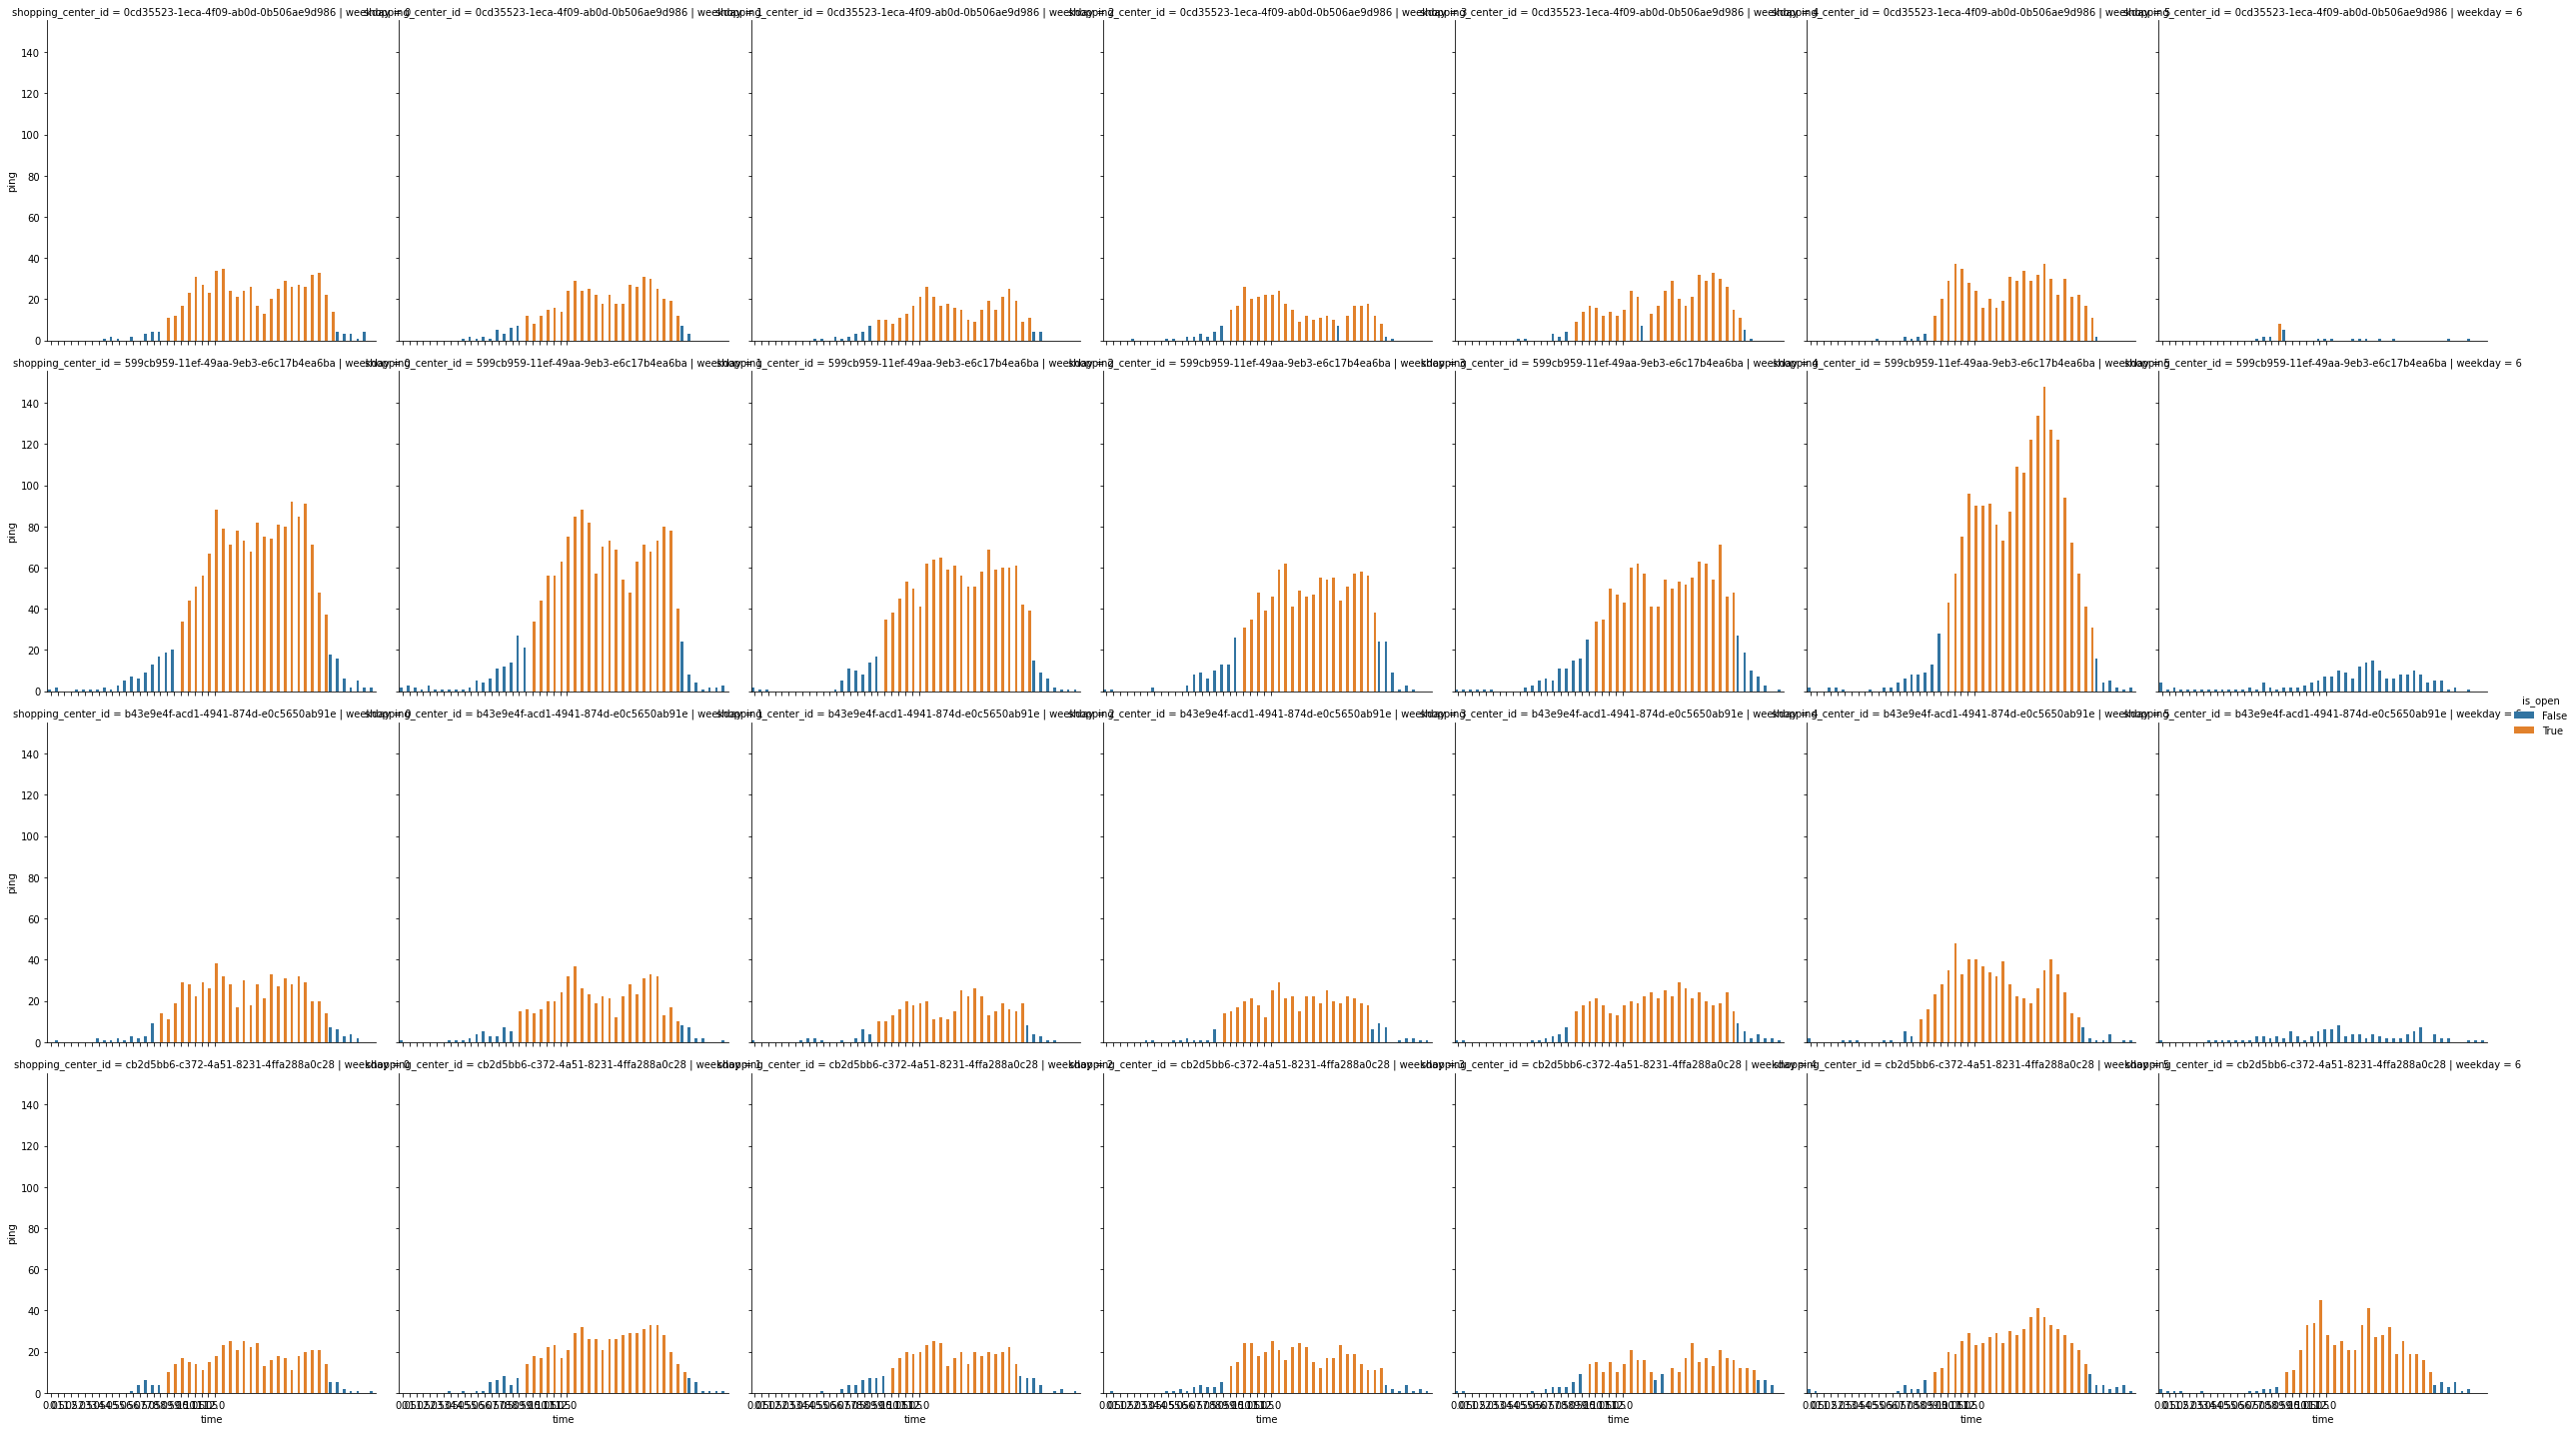

In [8]:
res = test_solution_fn(predict_open_with_treshold, all_center)
plt.show()

# Unsupervised Learning

## K-means

In [9]:
from sklearn.cluster import KMeans

In [10]:
# # Test with kmeans

# test_data = all_center["b43e9e4f-acd1-4941-874d-e0c5650ab91e"][0]
# # test_data
# X = np.array([[0, n] for i, n in enumerate(test_data)])

# kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# kmeans.cluster_centers_

# def plot_k_means_result(kmeans, x, one_d=True):
#     if one_d:
#         plt.scatter(np.arange(0, 24, 24 / X.shape[0]), x[:, 1], c=kmeans.labels_, cmap='rainbow')
#     else:
#         plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_, cmap='rainbow')

#     plt.plot([0,24], [kmeans.cluster_centers_[0][1]]*2, c='black')
#     plt.plot([0, 24], [kmeans.cluster_centers_[1][1]]*2, c='black')
#     plt.show()

# plot_k_means_result(kmeans, X)

In [11]:
# def predict_open_with_kmeans_by_day(x):
#     fake_2d_x = np.array([[0, n] for n in x])
#     return KMeans(n_clusters=2, random_state=0).fit_predict(fake_2d_x)

# # test_solution_fn(predict_open_with_kmeans_by_day, all_center)

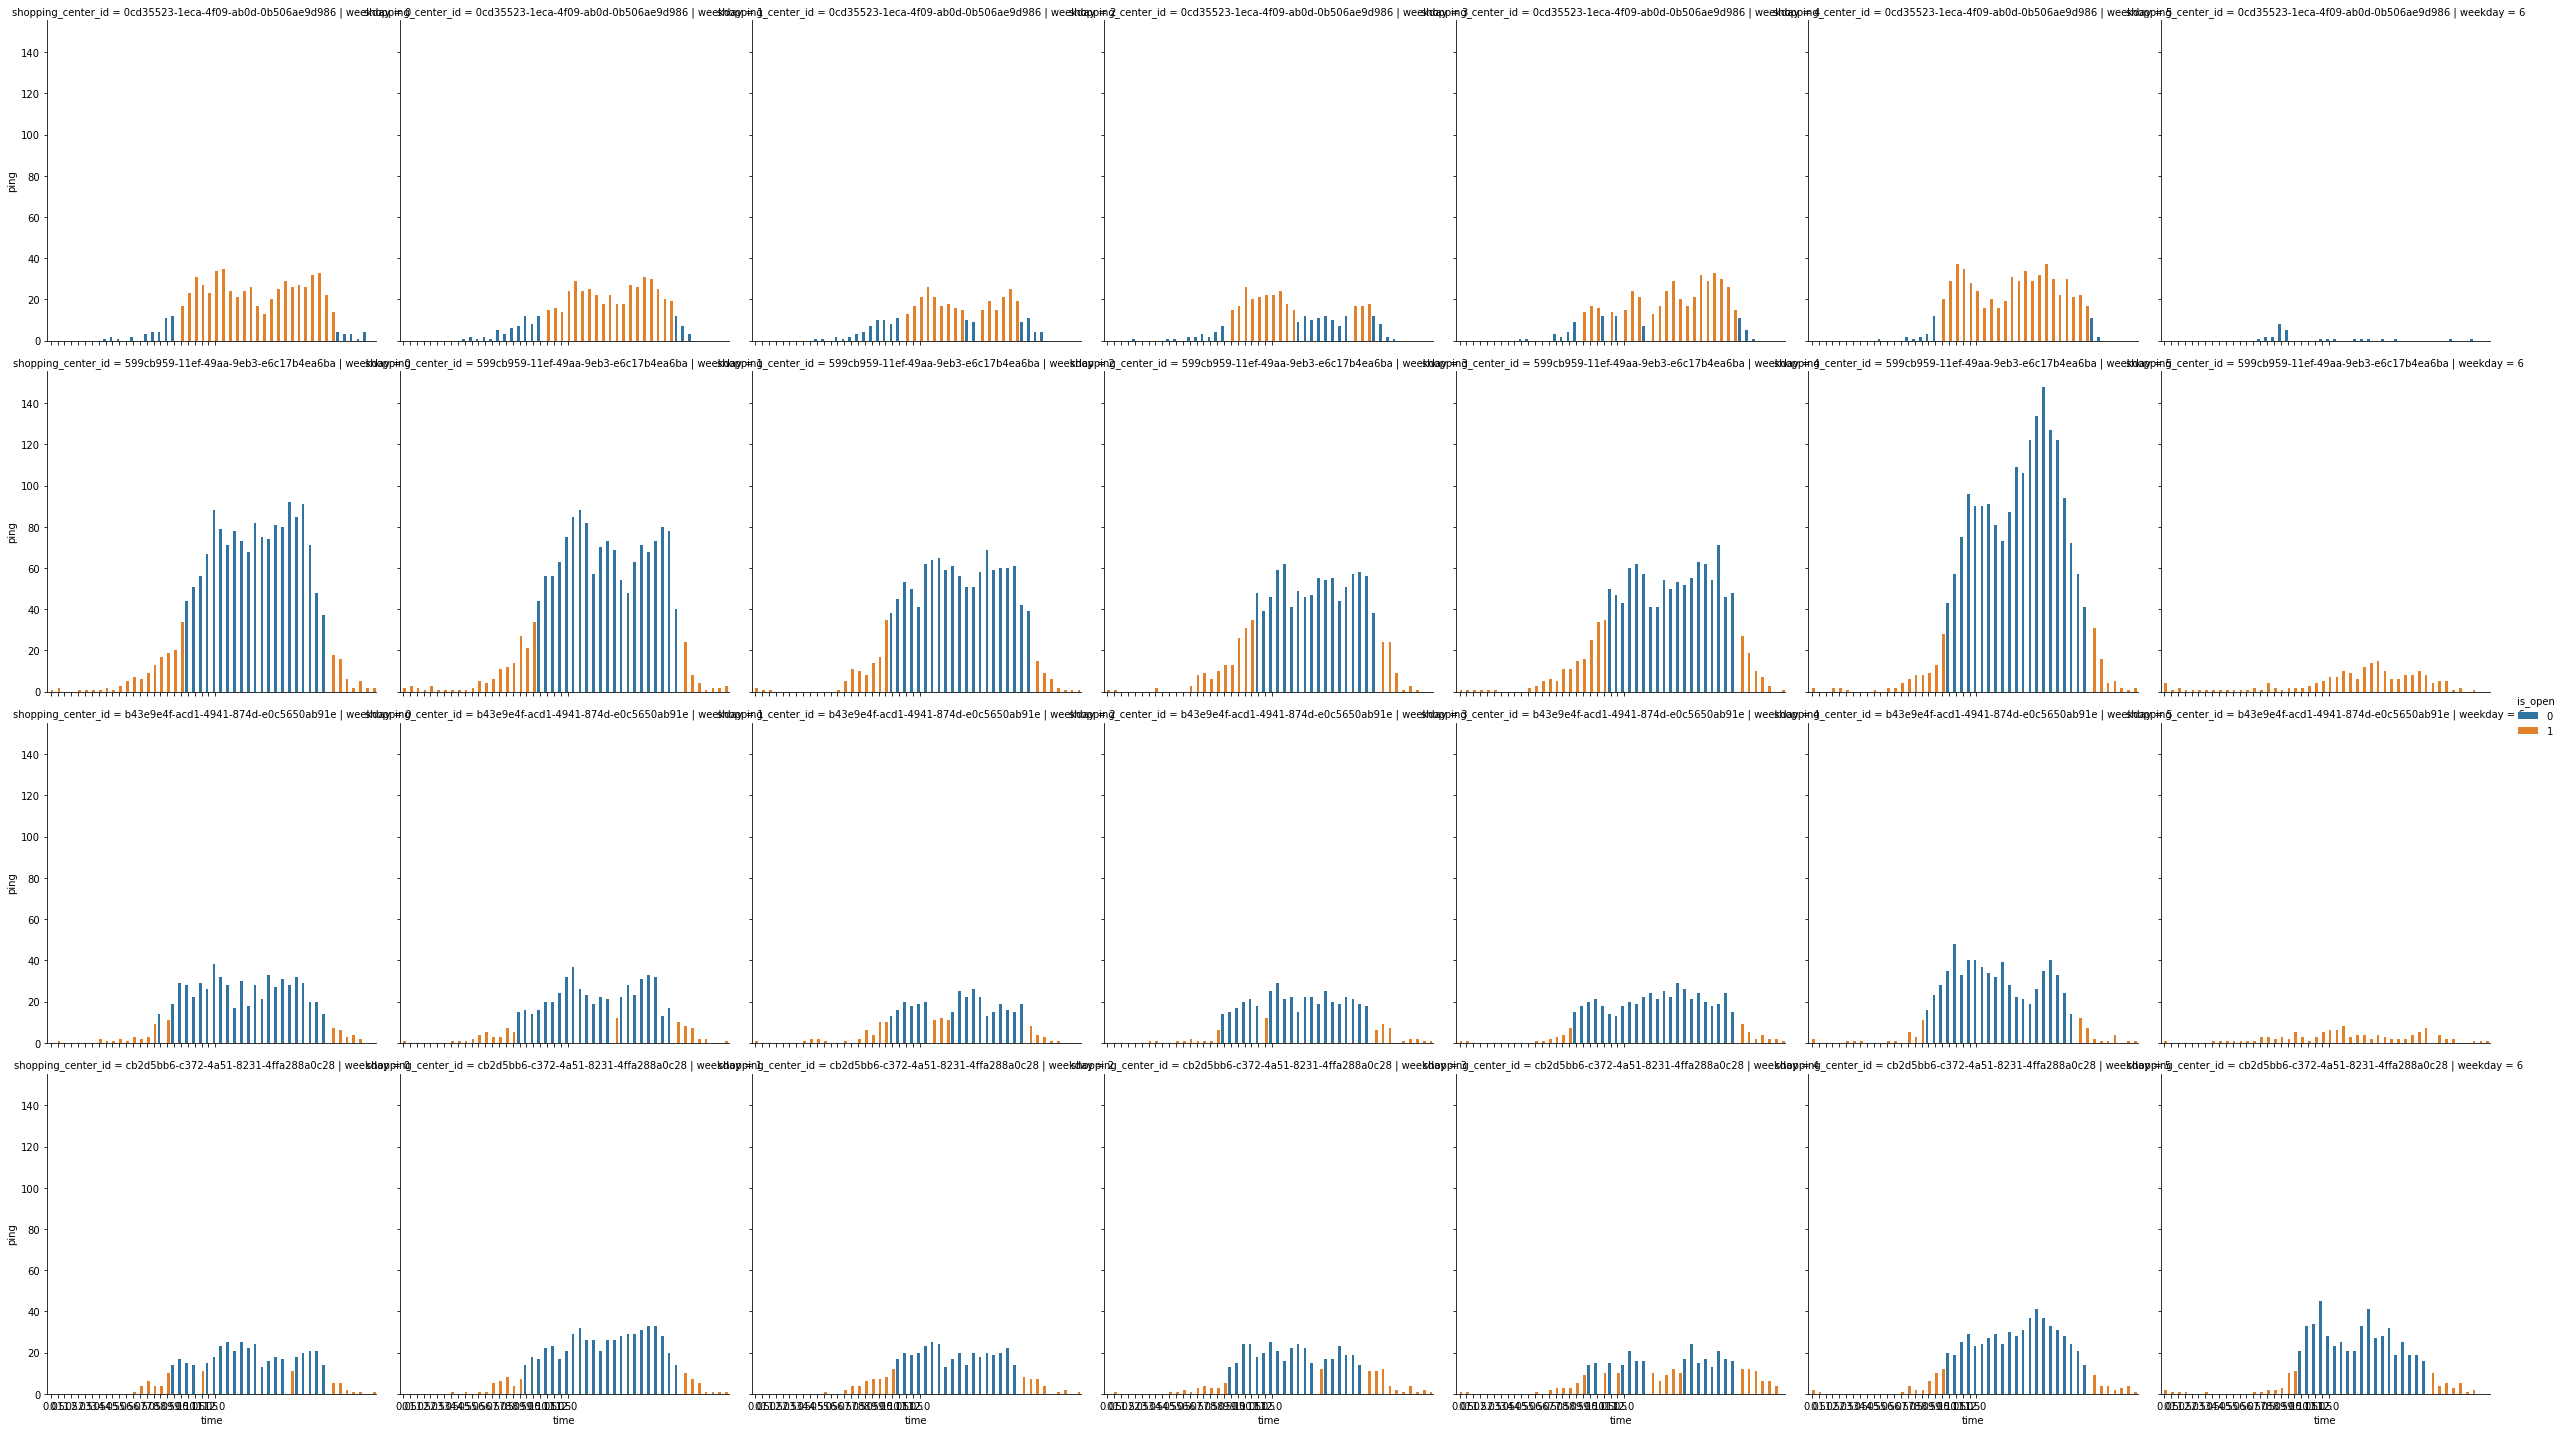

In [13]:
def predict_open_with_kmeans_by_center(center_data):
    train_data = [[0, val] for val_lst in center_data.values() for val in val_lst]
    kmeans = KMeans(n_clusters=2, random_state=0).fit(train_data)

    return {k: kmeans.predict([[0, v] for v in val_lst]) for k, val_lst in center_data.items()}

res = test_solution_fn(predict_open_with_kmeans_by_center, all_center)
plt.show()

# Times series approach

_Offline change detection in time series_ ?